In [38]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm



# Base data directory
DATA_DIR = Path("data")

In [2]:
acs_dtypes = {
    "geo_id": str,
    "year": int,
    "median_income": float,
    "total_pop": int,
    "median_age": float,
    "white_pop": float,
    "black_pop": float,
    "hispanic_pop": float,
    "asian_pop": float,
    "bachelors_degree_or_higher_25_64": float,
    "less_than_high_school_graduate": float,
    "some_college_and_associates_degree": float,
    "percent_income_spent_on_rent": float,
    "different_house_year_ago_same_city": float,
    "different_house_year_ago_different_city": float,
    "median_rent": float,
    "rent_over_50_percent": float,    
    "poverty": float,
    "gini_index": float
}

acs_df = pd.read_csv(DATA_DIR / "acs_multi_year_panel.csv", dtype=acs_dtypes)

# Sanity check FIPS formatting
acs_df["geo_id"] = acs_df["geo_id"].str.zfill(5)

# Drop nulls in income (2 rows)
acs_df = acs_df.dropna(subset=["median_income"])

# Fill minor gaps with  less than 10 nulls
minor_cols = ["median_rent", "percent_income_spent_on_rent", "rent_over_50_percent", "poverty", "gini_index"]
acs_df[minor_cols] = acs_df[minor_cols].fillna(acs_df[minor_cols].median())

acs_df.head()

,geo_id,state_fips,county_fips,year,median_income,total_pop,median_age,white_pop,black_pop,hispanic_pop,...,bachelors_degree_or_higher_25_64,less_than_high_school_graduate,some_college_and_associates_degree,different_house_year_ago_same_city,different_house_year_ago_different_city,median_rent,percent_income_spent_on_rent,rent_over_50_percent,poverty,gini_index
0,05025,5,25,2020,46349.0,8063,42.5,6807.0,1087.0,0.0,...,766.0,601.0,1579.0,41.0,360.0,379.0,20.2,72.0,1173.0,0.4314
1,08009,8,9,2020,34655.0,3570,45.9,3005.0,33.0,404.0,...,393.0,369.0,896.0,138.0,257.0,316.0,21.2,35.0,625.0,0.4696
2,13307,13,307,2020,31629.0,2587,43.9,1372.0,850.0,322.0,...,141.0,378.0,673.0,60.0,113.0,237.0,34.7,0.0,637.0,0.4986
3,16059,16,59,2020,38819.0,7929,53.4,7408.0,2.0,264.0,...,927.0,483.0,2490.0,194.0,847.0,514.0,35.6,147.0,1063.0,0.4570
4,16077,16,77,2020,51014.0,7635,38.8,4682.0,2.0,2596.0,...,583.0,951.0,1366.0,882.0,674.0,483.0,18.6,16.0,915.0,0.4167


In [3]:
weather_dtypes = {
    "station_id": str,
    "year": int,
    "quarter": int,
    "avg_temp": float,
    "max_temp": float,
    "total_precip": float,
    "heat_days_90F": int,
    "hail_days": int,
    "thunder_days": int,
    "tornado_days": int,
    "num_days": int
}

# Load GSOD aggregates
weather_df = pd.read_csv(DATA_DIR / "gsod_quarterly_aggregates.csv", dtype=weather_dtypes)

weather_df.head()

,station_id,year,quarter,avg_temp,max_temp,total_precip,heat_days_90F,hail_days,thunder_days,tornado_days,num_days
0,010010-99999,2000,1,23.235165,42.1,8.25,0,0,0,0,91
1,010010-99999,2000,2,30.638462,46.8,4.77,0,0,0,0,91
2,010010-99999,2000,3,41.803261,54.3,7.82,0,0,0,0,92
3,010010-99999,2000,4,31.369565,44.1,7.66,0,0,0,0,92
4,010014-99999,2000,1,38.245455,46.4,0.00,0,0,0,0,22


In [4]:
station_dtype = {
    "usaf": str,
    "wban": str,
    "name": str,
    "country": str,
    "state": str,
    "lat": float,
    "lon": float,
    "elev": str  # keep as str to preserve sign and format
    }

# Load file
stations_df = pd.read_csv(
    DATA_DIR / "noaa_stations.csv",
    dtype=station_dtype,
    parse_dates=["begin", "end"]
)

stations_df.head()

,usaf,wban,name,country,state,lat,lon,elev,begin,end,station_id
0,690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,36.000,-121.233,+0317.0,2003-07-02,2003-08-01,690020-99999
1,690190,13910,ABILENE DYESS AFB,US,TX,32.433,-99.850,+0545.3,1943-12-01,2009-12-31,690190-13910
2,690190,99999,DYESS AFB/ABILENE,US,TX,32.417,-99.850,+0545.0,2000-01-03,2004-12-30,690190-99999
3,690230,24255,WHIDBEY ISLAND NAS,US,WA,48.350,-122.667,+0014.3,1989-12-01,2009-06-02,690230-24255
4,690260,99999,CHEBOYGAN,US,MI,45.650,-84.467,+0176.0,1980-06-11,2001-10-23,690260-99999


In [ ]:
storm_dtypes = {
    "geo_id": str,
    "year": int,
    "quarter": int,
    "event_type": str,
    "num_events": int,
    "total_property_damage": float,
    "total_crop_damage": float,
    "total_injuries": int,
    "total_deaths": int
}

storm_df = pd.read_csv(DATA_DIR / "storm_events_by_county_quarter.csv", dtype=storm_dtypes)

print("Loaded storm event data:", storm_df.shape)
storm_df.head()

✅ Loaded storm event data: (330416, 9)


,geo_id,year,quarter,event_type,num_events,total_property_damage,total_crop_damage,total_injuries,total_deaths
0,33007,2000,2,debris flow,1,0.0,0.0,0,0
1,36001,2000,2,debris flow,1,500000.0,0.0,0,0
2,51009,2000,1,dust devil,1,3000.0,0.0,0,0
3,32031,2000,3,dust devil,1,1000.0,0.0,0,0
4,21015,2000,1,flash flood,3,25000.0,0.0,0,0


In [13]:
shapefile_path = Path("Data/cb_2023_us_county_5m/cb_2023_us_county_5m.shp")

counties = gpd.read_file(shapefile_path)

# Project to WGS84 (matches lat/lon)
counties = counties.to_crs("EPSG:4326")

# Create a unique FIPS code for join
counties["geo_id"] = counties["STATEFP"] + counties["COUNTYFP"]

# Select relevant columns
counties = counties[["geo_id", "NAME", "STATEFP", "COUNTYFP", "geometry"]]
counties.head()

,geo_id,NAME,STATEFP,COUNTYFP,geometry
0,13065,Clinch,13,065,"POLYGON ((-82.9705 30.94981, -82.97125 31.1839..."
1,21083,Graves,21,083,"POLYGON ((-88.81724 36.76775, -88.81323 36.773..."
2,37177,Tyrrell,37,177,"POLYGON ((-76.4056 35.78629, -76.35367 35.8613..."
3,38013,Burke,38,013,"POLYGON ((-102.93896 48.99928, -102.67765 48.9..."
4,40059,Harper,40,059,"POLYGON ((-100.00371 36.79697, -100.00256 37.0..."


In [14]:
# Convert stations_df to a GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["lon"], stations_df["lat"]),
    crs="EPSG:4326"
)

# Perform spatial join (retains station geometry by default)
joined = gpd.sjoin(
    stations_gdf,
    counties[["geo_id", "NAME", "geometry"]],
    how="left",
    predicate="within"
)

# Rename county geometry to keep it
joined = joined.rename(columns={"geometry": "station_geometry", "NAME": "county_name"})

# Add back county geometry explicitly
joined = joined.merge(
    counties[["geo_id", "geometry"]].rename(columns={"geometry": "county_geometry"}),
    on="geo_id",
    how="left"
)

# Keep what's relevant, now with county geometry
stations_with_fips = gpd.GeoDataFrame(
    joined[["station_id", "geo_id", "county_name", "lat", "lon", "county_geometry"]],
    geometry="county_geometry",
    crs="EPSG:4326"
)

# Filter out non-US stations
weather_df = weather_df[weather_df["station_id"].isin(stations_with_fips["station_id"])]

# Merge Weather and Station data to eventually merge with ACS data
weather_df = weather_df.merge(stations_with_fips[["station_id", "geo_id", "county_name", "county_geometry"]], on="station_id", how="left")

In [15]:
def pivot_storm_events_by_type(
    storm_df: pd.DataFrame,
    top_n: int = None
) -> pd.DataFrame:
    
    storm_df = storm_df.copy()
    metrics = [
        "num_events",
        "total_injuries",
        "total_deaths",
        "total_property_damage",
        "total_crop_damage"
    ]

    storm_df[metrics] = storm_df[metrics].fillna(0)

    # Auto-select most impactful event types
    if top_n is not None:
        summary = storm_df.groupby("event_type").agg(
            total_deaths=("total_deaths", "sum"),
            total_damage=("total_property_damage", "sum")
        )
        summary["combined_impact"] = summary["total_deaths"] + (summary["total_damage"] / 1_000_000)  # scale damage
        top_event_types = summary.sort_values(by="combined_impact", ascending=False).head(top_n).index.tolist()
        storm_df = storm_df[storm_df["event_type"].isin(top_event_types)]

    # Pivot the filtered data
    pivot = storm_df.pivot_table(
        index=["geo_id", "year", "quarter"],
        columns="event_type",
        values=metrics,
        aggfunc="sum",
        fill_value=0
    )

    pivot.columns = [
        f"{metric}_{event_type.replace(' ', '_').lower()}"
        for metric, event_type in pivot.columns
    ]

    return pivot.reset_index()


In [16]:
# Run severe weather data through function to flatten data and highlight most impactful events
storm_wide = pivot_storm_events_by_type(storm_df, top_n=10)
print(storm_wide.columns)

Index(['geo_id', 'year', 'quarter', 'num_events_debris_flow',
       'num_events_flash_flood', 'num_events_flood', 'num_events_hail',
       'num_events_heavy_rain', 'num_events_lightning',
       'num_events_rip_current', 'num_events_thunderstorm_wind',
       'num_events_tornado', 'num_events_wildfire',
       'total_crop_damage_debris_flow', 'total_crop_damage_flash_flood',
       'total_crop_damage_flood', 'total_crop_damage_hail',
       'total_crop_damage_heavy_rain', 'total_crop_damage_lightning',
       'total_crop_damage_rip_current', 'total_crop_damage_thunderstorm_wind',
       'total_crop_damage_tornado', 'total_crop_damage_wildfire',
       'total_deaths_debris_flow', 'total_deaths_flash_flood',
       'total_deaths_flood', 'total_deaths_hail', 'total_deaths_heavy_rain',
       'total_deaths_lightning', 'total_deaths_rip_current',
       'total_deaths_thunderstorm_wind', 'total_deaths_tornado',
       'total_deaths_wildfire', 'total_injuries_debris_flow',
       'total_inj

In [17]:
# Aggregate station data by county to merge with ACS data
county_weather = weather_df.groupby(["geo_id", "county_name", "year", "quarter", "county_geometry"]).agg(
    avg_temp=("avg_temp", "mean"),
    max_temp=("max_temp", "max"),
    total_precip=("total_precip", "mean"),
    heat_days_90F=("heat_days_90F", "mean"),
    hail_days=("hail_days", "mean"),
    thunder_days=("thunder_days", "mean"),
    tornado_days=("tornado_days", "mean"),
    reporting_stations=("station_id", "nunique"),
    total_days=("num_days", "mean")
).reset_index()

county_weather.head()

,geo_id,county_name,year,quarter,county_geometry,avg_temp,max_temp,total_precip,heat_days_90F,hail_days,thunder_days,tornado_days,reporting_stations,total_days
0,01003,Baldwin,2006,2,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",78.274468,96.8,0.000,16.0,0.0,0.0,0.0,1,47.0
1,01003,Baldwin,2006,3,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",79.402209,95.0,5.665,22.0,0.0,3.0,0.0,2,63.0
2,01003,Baldwin,2006,4,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",58.596920,89.6,4.635,0.0,0.0,0.0,0.0,2,80.5
3,01003,Baldwin,2007,1,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",53.967616,82.8,4.005,0.0,0.0,0.0,0.0,2,76.0
4,01003,Baldwin,2007,2,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",71.111974,95.2,5.695,6.5,0.0,0.0,0.0,2,74.5


In [18]:
# Merge ACS data with county level quarterly weather data
weather_with_acs = county_weather.merge(
    acs_df,
    on=["geo_id", "year"],
    how="left"
)

# Include severe weather data with the merged df
weather_with_acs = weather_with_acs.merge(storm_wide, on=["geo_id", "year", "quarter"], how="left")

# Fill storm-related NaNs with 0
storm_cols = [col for col in weather_with_acs.columns if "total_" in col or "num_events" in col] # TODO fix total_pop fill
weather_with_acs[storm_cols] = weather_with_acs[storm_cols].fillna(0)

# Flag for downstream modeling since we have more  weather data than acs data currently
weather_with_acs["has_acs"] = weather_with_acs["median_income"].notna().astype(int)

# Training only subset
training_data = weather_with_acs[weather_with_acs["has_acs"] == 1].copy()
training_data.to_csv(DATA_DIR / "county_weather_acs_training.csv", index=False)

# Store complete dataset including nulls
weather_with_acs.to_csv(DATA_DIR / "county_weather_acs_complete.csv", index=False)

print("Merged shape:", weather_with_acs.shape)
print("Training shape:", training_data.shape)
print(weather_with_acs.info())


Merged shape: (142272, 84)
Training shape: (66600, 84)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142272 entries, 0 to 142271
Data columns (total 84 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   geo_id                                   142272 non-null  object  
 1   county_name                              142272 non-null  object  
 2   year                                     142272 non-null  int64   
 3   quarter                                  142272 non-null  int64   
 4   county_geometry                          142272 non-null  geometry
 5   avg_temp                                 142272 non-null  float64 
 6   max_temp                                 142272 non-null  float64 
 7   total_precip                             142272 non-null  float64 
 8   heat_days_90F                            142272 non-null  float64 
 9   hail_days                            

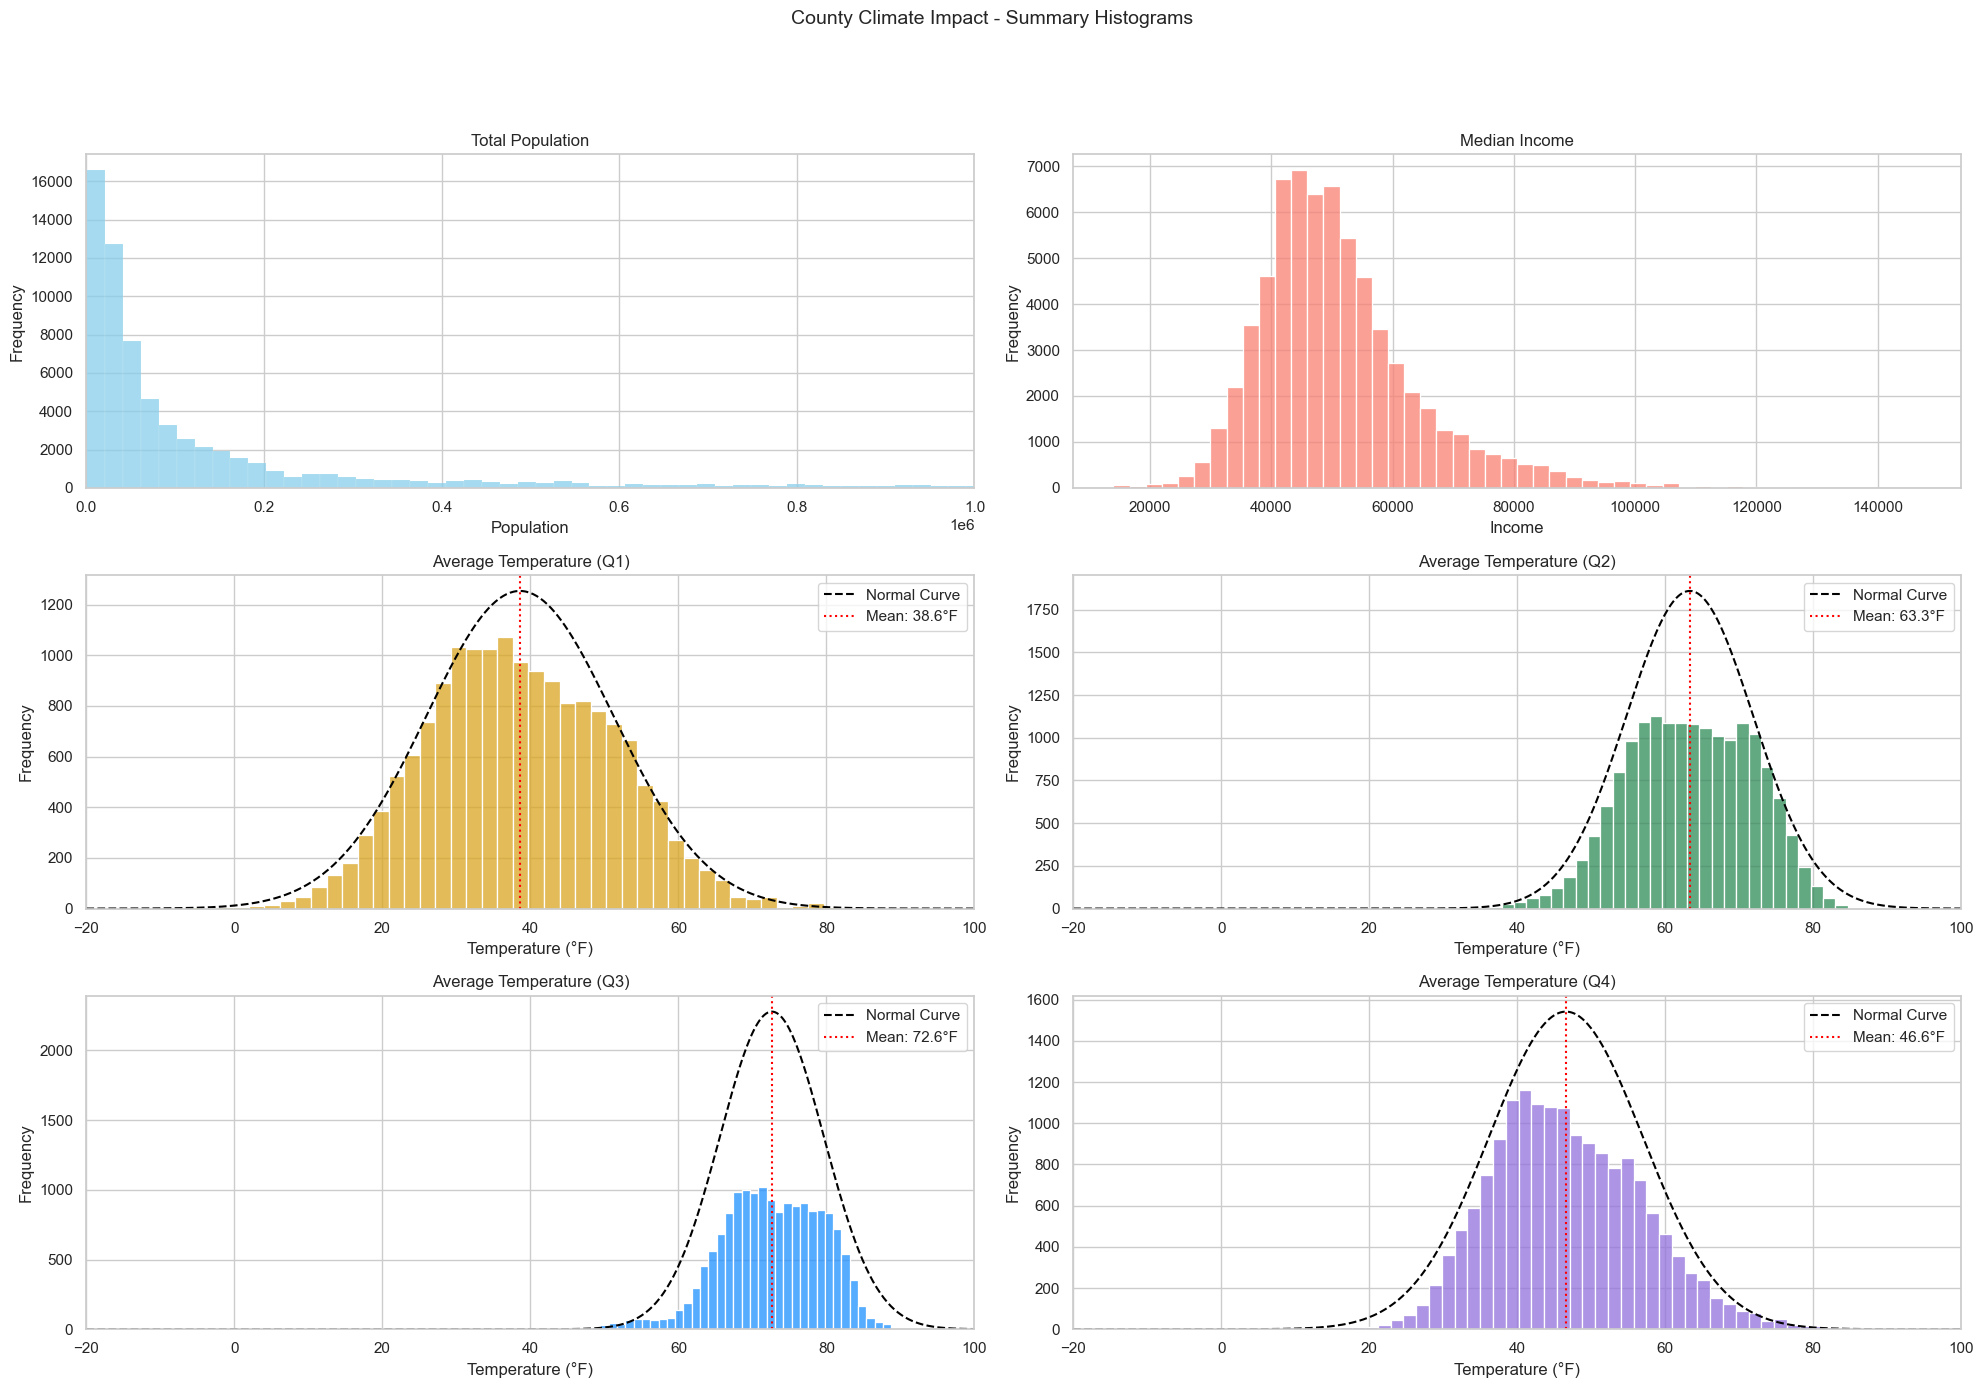

In [39]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(3,2, figsize=(20,14))
fig.suptitle("County Climate Impact - Summary Histograms", fontsize=14, y=1.02)

sns.histplot(training_data["total_pop"], bins=500,  ax=axs[0,0], color="skyblue")
axs[0,0].set_title("Total Population")
axs[0,0].set_xlabel("Population")
axs[0,0].set_ylabel("Frequency")
axs[0,0].set_xlim(0,1_000_000)

sns.histplot(training_data["median_income"], bins=50,  ax=axs[0,1], color="salmon")
axs[0,1].set_title("Median Income")
axs[0,1].set_xlabel("Income")
axs[0,1].set_ylabel("Frequency")

# Define quarter-to-color mapping
colors = {
    1: "goldenrod",
    2: "seagreen",
    3: "dodgerblue",
    4: "mediumpurple"
}

# Loop through quarters for temperature histograms
for i, quarter in enumerate([1, 2, 3, 4]):
    row, col = divmod(i + 2, 2)
    data = training_data[training_data["quarter"] == quarter]["avg_temp"].dropna()

    mean = data.mean()
    std = data.std()
    x_range = np.linspace(-20, 100, 500)
    y_norm = norm.pdf(x_range, mean, std) * len(data) * (120 / 50)  # scale to histogram height

    sns.histplot(data, bins=50, ax=axs[row, col], color=colors[quarter])
    axs[row, col].plot(x_range, y_norm, color="black", linestyle="--", linewidth=1.5, label="Normal Curve")
    axs[row, col].axvline(mean, color="red", linestyle=":", linewidth=1.5, label=f"Mean: {mean:.1f}°F")

    axs[row, col].set_title(f"Average Temperature (Q{quarter})")
    axs[row, col].set_xlabel("Temperature (°F)")
    axs[row, col].set_ylabel("Frequency")
    axs[row, col].set_xlim(-20, 100)
    axs[row, col].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()